# **Assignment 2: Content Analysis and Regression**

For this assignment, you need to test a hypothesis using multiple linear regression. Before doing that, you also need to use computational content analysis and NLP techniques to create new variables that you will use as a predictor in the regression model.

##**Research Background**##

According to Chatman (1980), characters are constructs within abstracted narratives, described through networks of personality traits (e.g., Sarrasine is feminine, Othello is jealous, Roland Deschain is brave). Docherty characterizes the process of depicting and interpreting characters in literature as 'characterization' (cited by Bennett and Royle, 2017). Reaske (1996) identifies several devices of characterization, including character appearance, asides and soliloquies, dialogue, hidden narration, language, and actions performed. Characterization is crucial in narrative because it allows readers to relate to characters and feel emotionally engaged in the story (Cohen, 2001). providing information on personalities and behaviors for gender representation analysis in fiction.

For this assignment, you'll work with a corpus of the genre Real Person Fiction (RPF), where characters are characterized by blending real-life traits with fans' interpretations and reimagination, reflecting societal and cultural trends.

On the online fanfiction platform AO3, fanfictions about the Korean boy band BTS represent the largest fandom, surpassing even the Marvel Universe and Harry Potter franchises. Research into the global popularity of the Korean Wave (*Hallyu*) has highlighted the concept of "manufactured versatile masculinity" exhibited by male K-pop idols, a blend of softer, more effeminate appearances or behaviors with traditional forms of hegemonic masculinity, described by scholars such as Jung (2011), Kuo et al. (2020), Kwon (2019), and Oh (2015). Oh (2015) terms this "liminal masculinity," with androgynous K-pop male idols crossing gender lines.

**Aim:**

This assignment aims to analyze the impact of soft masculinity on K-pop fanfiction's success using a corpus of 100 BTS fanfictions.

**Data:**

We will utilize a dataset from the GOLEM project, comprising 100 BTS-related fanfictions, including story ID, publication year, word count, kudos, comments, and story content in English (1,000 to 1,200 words).

**Methods:**
- operationalize the concept of 'soft masculinity' to make it measurable
- use regression analysis to test a hypothesis

In [1]:
# Load and check the dataset
import pandas as pd

df = pd.read_csv('BTS_short_100.csv', encoding="UTF-8")
df.head()

,story_id,published_year,words,kudos,comments,story_content
0,4706144,2015,1185,249.0,1.0,library snacks & 3AM promises\n\nAuthor's Note...
1,4752980,2015,1164,79.0,NaN,Worry\n\nYou stumbled through the apartment do...
2,4706144,2015,1185,249.0,1.0,library snacks & 3AM promises\n\nAuthor's Note...
3,4621698,2015,1016,105.0,4.0,Mornings\n\nThis is literally trash omg what I...
4,4752980,2015,1164,79.0,NaN,Worry\n\nYou stumbled through the apartment do...


Have you noticed something odd in the first five lines of this dataset?

There are some duplicates.

So first we need to do some data cleaning, checking how many rows are duplicated and deleting the duplicates.


In [2]:
# Get the number of unique rows
unique_story_ids = df['story_id'].nunique()

# Print the result
print(f"The number of unique 'story_id' values is: {unique_story_ids}")

The number of unique 'story_id' values is: 90


In [3]:
# Remove duplicate rows
df = df.drop_duplicates()

df.head()

,story_id,published_year,words,kudos,comments,story_content
0,4706144,2015,1185,249.0,1.0,library snacks & 3AM promises\n\nAuthor's Note...
1,4752980,2015,1164,79.0,NaN,Worry\n\nYou stumbled through the apartment do...
3,4621698,2015,1016,105.0,4.0,Mornings\n\nThis is literally trash omg what I...
5,3651108,2015,1174,339.0,6.0,Purple Gel Pens\n\nAuthor's Note:\n\nwtf is th...
7,5282729,2015,1173,17.0,NaN,"Unspoken Words\n\nYou come back into the flat,..."


In [4]:
# Let's check how many rows there are now
df.shape[0]

90

## **Research Design**##
The steps of this research involve formulating a hypothesis, selecting `kudos` as a proxy for the success of a story -- the dependent variable (Y) -- and calculating a masculinity score to be used as the independent variable (x1). We will also use additional variables that are also likely to have an effect on the success of a story: `publication_year` (x2) - because AO3 user base has grown in time and more recent stories are more likely to receive more kudos simply becasue there are more readers on the platform - and lexical richness (x3) - because it's plausible that a story with a richer vocabulary also has a better style and, therefore, it's liked more by readers.

Note that we don't have variables for `masculinity_score` and `lexical_richness` yet, so we need to calculate them from the text of the stories.

The hypothesis states:

H1: Low levels of masculinity in male characters positively affects fanfiction success when controlling for publication year and lexical richness.

**H0: What is the null hypothesis?**

**H0 (answer in words):**<br>
Low levels of masculinity in male characters (masculine_power_score - independent variable X1) have no effect on fanfiction success (kudos - dependent variable Y) when controlling for publication year (published_year - independent variable X2) and lexical richness (lexical_richness - independent variable X3).<br>
The predictors (independent variables - masculine_power_score, published_year and lexical_richness) have no effect on the response variable (dependent variable - kudos).

##**Compute Masculinity Score**##

To calculate a sterotypical masculinity score, we can refer to older theories of perceived gender identity that probably define gender roles in a stereotypical way. an example of this is the Bem Sex-Role Inventory (BSRI) by Dr. Sandra Lipzits Bem (1974), which classifies personality traits into masculine, feminine, and androgynous.

Bem divides personal traits into 60 traits: 20 masculine traits, 20 feminine traits and 20 neutral traits (see figure below).


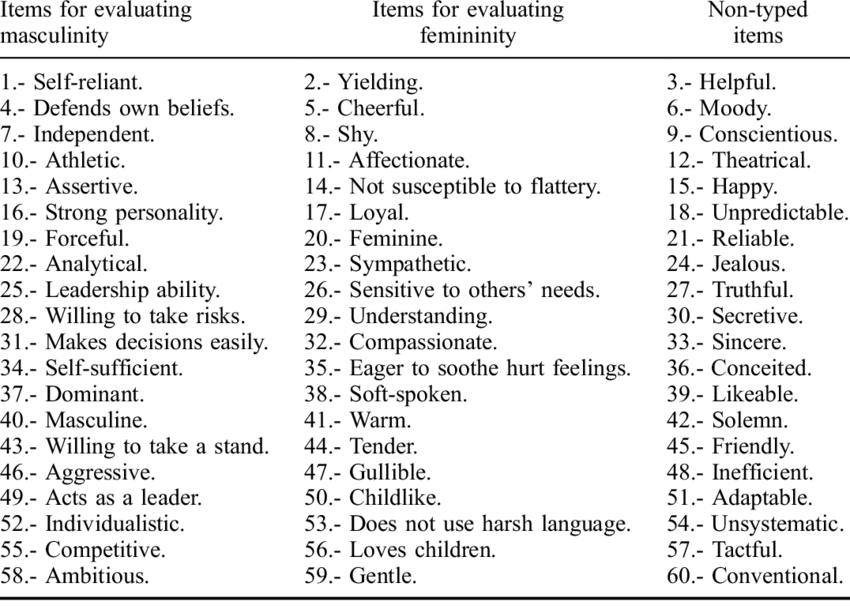

The above list shows that, despite recent discussions about masculinity, femininity, and gender roles have become more diversified, traditional definitions such as those provided by the Bem Sex-Role Inventory (BSRI) can be useful to detect gender stereotypes. Within the definitions of masculinity and femininity outlined by the BSRI, we observe a clear power imbalance: masculinity is associated with dominance (e.g., assertive, strong personality, forceful, leadership ability, dominant, aggressive, ambitious), while femininity leans towards submissiveness (e.g., yielding, understanding, tender). Therefore, we can consider employing the power-agent frames designed by Sap et al. to compute a power score for the male characters in the fanfiction stories. Lower masculinity scores can be plausibly associated with a representation of 'soft masculinity' in relation to a character.

###**Riveter**###

In the W5 lab, we have already gained preliminary experience with the Riveter pipeline.

In this section, we will use utilize the Riveter pipeline with Sap's power-agent frames to calculate the `masculinity_score` for identifiable agents in the text. Since we are interested only in the masculinity of male characters, we will use regular expressions to identify male pronouns (he, him, himself) and calculate their corresponding `masculinity_score`. This score will be added to the df as a new column.


In [5]:
# Set up everything you need to use Riveter, following the notebook we used in W5 lab
# No need to put the code here, as long as it's working
# We assume that you have installed all the required packages, either locally or on Colab

Now we have prepared all the dependencies needed.

In [6]:
from collections import defaultdict #  Defaultdict overrides one method and adds one writable instance variable. 
import os
import pandas as pd # used for data wrangling, working with dataframes
import random
from riveter import Riveter # used for calculating the masculinity_score for identifiable male characters in the text

import seaborn as sns # used for visualization
import matplotlib.pyplot as plt # used for visualization, for creating plots

**Prepare the corpus**:

First, we can try to initialize two lists to store `story_content` and `story_id`, but this will casue the problem below:

`Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512).`

This is a limit of the language model (BERT) used by Riveter. We need to split the file into smaller chunks in order for it to be processed correctly. The example in the original Riveter notebook where they load *Pride and Prejudice* shows how we can do this. The code is also provided here below.




In [7]:
def split_text_into_segments(text, max_length=512):
    """
    Segment the text so that each segment contains a maximum of max length tokens.
    """
    segments = []
    current_segment = []
    for word in text.split():
        if len(current_segment) + len(word.split()) <= max_length:
            current_segment.append(word)
        else:
            segments.append(' '.join(current_segment))
            current_segment = [word]
    if current_segment:
        segments.append(' '.join(current_segment))
    return segments

Let's first initialize Riveter with the lexicon that we are going to use:

In [8]:
# Q0 (code): Load lexicon 'power' and create an empty dictionary called 'scores_dict'
riveter = Riveter()
riveter.load_sap_lexicon('power')

scores_dict = {}

Now we can apply the splitting function we defined above and then use Riveter on our corpus. To do this, we need to create a loop that iterates through all the rows in the dataframe and compute scores for each story.

**Q1. Train Riveter to assign scores to text based on male pronouns**

In [9]:
from tqdm import tqdm # used to display a progress bar when executing code

for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing stories"):
    story_id = row['story_id']
    story_content = row['story_content']

    # apply the splitting function:
    segments = split_text_into_segments(story_content)
    text_ids = [f"{story_id}_{i}" for i in range(len(segments))]

    # Q1 (code): train riveter specifying 'persona_patterns_dict= ' to assign scores only based on male pronouns
    # write code below:
    riveter.train(segments,
             text_ids,
             num_bootstraps=20,
             persona_patterns_dict={'masculine': r'^he$|^him$|^himself$'})
    
    # store the computed scores in a dictionary
    persona_score_dict = riveter.get_score_totals()
    masculine_score = persona_score_dict.get('masculine', 0)

    # get a feedback about the computed scores while the code is running
    print(f"Story ID: {story_id}, Masculine Power Score: {masculine_score}")

    # store the score of each story in the same dictionary so that we can then add it to the dataframe
    scores_dict[story_id] = masculine_score

# add the dictionary of scores to the dataframe
df['masculine_power_score'] = df['story_id'].map(scores_dict)

Processing stories:   1%|          | 1/90 [00:20<30:11, 20.36s/it]

2024-03-15 16:08:35 Complete!
Story ID: 4706144, Masculine Power Score: 0.08273839619779552



Processing stories:   2%|▏         | 2/90 [00:38<28:20, 19.33s/it]

2024-03-15 16:08:54 Complete!
Story ID: 4752980, Masculine Power Score: 0.262853095519939



Processing stories:   3%|▎         | 3/90 [00:54<25:44, 17.76s/it]

2024-03-15 16:09:10 Complete!
Story ID: 4621698, Masculine Power Score: 0.6311111111111112



Processing stories:   4%|▍         | 4/90 [01:13<25:59, 18.14s/it]

2024-03-15 16:09:28 Complete!
Story ID: 3651108, Masculine Power Score: 0.11337558817705877



Processing stories:   6%|▌         | 5/90 [01:35<27:32, 19.44s/it]

2024-03-15 16:09:50 Complete!
Story ID: 5282729, Masculine Power Score: 0.20812690849226612



Processing stories:   7%|▋         | 6/90 [01:57<28:33, 20.40s/it]

2024-03-15 16:10:12 Complete!
Story ID: 5533886, Masculine Power Score: -0.005446428571428572



Processing stories:   8%|▊         | 7/90 [02:17<28:13, 20.40s/it]

2024-03-15 16:10:33 Complete!
Story ID: 4547622, Masculine Power Score: 0.06933481795132654



Processing stories:   9%|▉         | 8/90 [02:36<27:07, 19.85s/it]

2024-03-15 16:10:51 Complete!
Story ID: 16177508, Masculine Power Score: 0.15272914652459907



Processing stories:  10%|█         | 9/90 [02:56<26:40, 19.76s/it]

2024-03-15 16:11:11 Complete!
Story ID: 15745185, Masculine Power Score: -0.11101328072280184



 33%|███▎      | 1/3 [00:09<00:19,  9.60s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors

Processing stories:  11%|█         | 10/90 [03:16<26:31, 19.89s/it]

2024-03-15 16:11:31 Complete!
Story ID: 15654528, Masculine Power Score: 0.19223731601591898



Processing stories:  12%|█▏        | 11/90 [03:34<25:36, 19.45s/it]

2024-03-15 16:11:49 Complete!
Story ID: 7448155, Masculine Power Score: 0.33139273830414717



Processing stories:  13%|█▎        | 12/90 [03:56<25:58, 19.98s/it]

2024-03-15 16:12:11 Complete!
Story ID: 4983847, Masculine Power Score: 0.08791161579574358



Processing stories:  14%|█▍        | 13/90 [04:17<26:23, 20.56s/it]

2024-03-15 16:12:33 Complete!
Story ID: 3313118, Masculine Power Score: -0.21262445887445888



Processing stories:  16%|█▌        | 14/90 [04:36<25:24, 20.06s/it]

2024-03-15 16:12:52 Complete!
Story ID: 3290390, Masculine Power Score: -0.11219330742624947



Processing stories:  17%|█▋        | 15/90 [04:58<25:38, 20.52s/it]

2024-03-15 16:13:13 Complete!
Story ID: 36435301, Masculine Power Score: 0.04571761762164239



Processing stories:  18%|█▊        | 16/90 [05:19<25:31, 20.70s/it]

2024-03-15 16:13:34 Complete!
Story ID: 36575491, Masculine Power Score: 0.25772149321722215



Processing stories:  19%|█▉        | 17/90 [05:39<24:46, 20.36s/it]

2024-03-15 16:13:54 Complete!
Story ID: 35225224, Masculine Power Score: 0.23939429473316937



Processing stories:  20%|██        | 18/90 [05:58<24:04, 20.07s/it]

2024-03-15 16:14:13 Complete!
Story ID: 4594527, Masculine Power Score: 0.15697649572649572



Processing stories:  21%|██        | 19/90 [06:16<22:57, 19.40s/it]

2024-03-15 16:14:31 Complete!
Story ID: 5485625, Masculine Power Score: 0.10199180130214613



Processing stories:  22%|██▏       | 20/90 [06:34<22:21, 19.17s/it]

2024-03-15 16:14:50 Complete!
Story ID: 36408319, Masculine Power Score: 0.14129087424443462



Processing stories:  23%|██▎       | 21/90 [06:57<23:21, 20.31s/it]

2024-03-15 16:15:13 Complete!
Story ID: 35762659, Masculine Power Score: 0.19462406391655357



Processing stories:  24%|██▍       | 22/90 [07:18<23:11, 20.46s/it]

2024-03-15 16:15:33 Complete!
Story ID: 35603194, Masculine Power Score: 0.3680576441102757



Processing stories:  26%|██▌       | 23/90 [07:39<22:54, 20.51s/it]

2024-03-15 16:15:54 Complete!
Story ID: 35344306, Masculine Power Score: 0.14314192467024528



Processing stories:  27%|██▋       | 24/90 [07:58<22:05, 20.09s/it]

2024-03-15 16:16:13 Complete!
Story ID: 36695155, Masculine Power Score: 0.09222222222222222



Processing stories:  28%|██▊       | 25/90 [08:20<22:20, 20.63s/it]

2024-03-15 16:16:35 Complete!
Story ID: 36064474, Masculine Power Score: 0.08710686046493887



Processing stories:  29%|██▉       | 26/90 [08:41<22:06, 20.73s/it]

2024-03-15 16:16:56 Complete!
Story ID: 36024820, Masculine Power Score: 0.14395582927931438



Processing stories:  30%|███       | 27/90 [09:39<33:41, 32.08s/it]

2024-03-15 16:17:55 Complete!
Story ID: 35182330, Masculine Power Score: 0.0615784627124237



Processing stories:  31%|███       | 28/90 [09:59<29:25, 28.48s/it]

2024-03-15 16:18:15 Complete!
Story ID: 36567496, Masculine Power Score: 0.21936189154114327



Processing stories:  32%|███▏      | 29/90 [10:21<26:54, 26.47s/it]

2024-03-15 16:18:36 Complete!
Story ID: 35560330, Masculine Power Score: 0.12614384189979985



Processing stories:  33%|███▎      | 30/90 [10:44<25:23, 25.39s/it]

2024-03-15 16:18:59 Complete!
Story ID: 35877496, Masculine Power Score: 0.05833907703497041



Processing stories:  34%|███▍      | 31/90 [11:04<23:20, 23.74s/it]

2024-03-15 16:19:19 Complete!
Story ID: 35957410, Masculine Power Score: 0.28604768386403967



Processing stories:  36%|███▌      | 32/90 [11:23<21:40, 22.43s/it]

2024-03-15 16:19:39 Complete!
Story ID: 30947654, Masculine Power Score: 0.0388857056434189



Processing stories:  37%|███▋      | 33/90 [11:45<21:02, 22.14s/it]

2024-03-15 16:20:00 Complete!
Story ID: 36332707, Masculine Power Score: -0.11137546106011678



Processing stories:  38%|███▊      | 34/90 [12:06<20:30, 21.98s/it]

2024-03-15 16:20:22 Complete!
Story ID: 35967940, Masculine Power Score: 0.1781449746292389



Processing stories:  39%|███▉      | 35/90 [12:27<19:48, 21.60s/it]

2024-03-15 16:20:42 Complete!
Story ID: 35001073, Masculine Power Score: 0.10072705072705072



Processing stories:  40%|████      | 36/90 [12:49<19:36, 21.78s/it]

2024-03-15 16:21:05 Complete!
Story ID: 35138911, Masculine Power Score: 0.13368388031985987



Processing stories:  41%|████      | 37/90 [13:09<18:33, 21.00s/it]

2024-03-15 16:21:24 Complete!
Story ID: 35280397, Masculine Power Score: 0.2231090510366826



Processing stories:  42%|████▏     | 38/90 [13:31<18:27, 21.30s/it]

2024-03-15 16:21:46 Complete!
Story ID: 36049939, Masculine Power Score: 0.3479888458308953



Processing stories:  43%|████▎     | 39/90 [13:53<18:22, 21.61s/it]

2024-03-15 16:22:08 Complete!
Story ID: 34995673, Masculine Power Score: 0.15408513501736337



Processing stories:  44%|████▍     | 40/90 [14:17<18:44, 22.49s/it]

2024-03-15 16:22:33 Complete!
Story ID: 33477346, Masculine Power Score: 0.4427525538187303



Processing stories:  46%|████▌     | 41/90 [14:37<17:38, 21.61s/it]

2024-03-15 16:22:52 Complete!
Story ID: 36840832, Masculine Power Score: -0.22495297100560258



Processing stories:  47%|████▋     | 42/90 [14:56<16:41, 20.86s/it]

2024-03-15 16:23:11 Complete!
Story ID: 30896276, Masculine Power Score: 0.04323308270676693



Processing stories:  48%|████▊     | 43/90 [15:14<15:38, 19.96s/it]

2024-03-15 16:23:29 Complete!
Story ID: 37363471, Masculine Power Score: 0.4355627705627706



Processing stories:  49%|████▉     | 44/90 [15:32<14:55, 19.46s/it]

2024-03-15 16:23:47 Complete!
Story ID: 36984901, Masculine Power Score: 0.19491183200969173



Processing stories:  50%|█████     | 45/90 [15:51<14:27, 19.28s/it]

2024-03-15 16:24:06 Complete!
Story ID: 33353644, Masculine Power Score: 0.013075429010501155



Processing stories:  51%|█████     | 46/90 [16:10<13:58, 19.06s/it]

2024-03-15 16:24:25 Complete!
Story ID: 37002835, Masculine Power Score: -0.13550855577171364



Processing stories:  52%|█████▏    | 47/90 [16:29<13:39, 19.06s/it]

2024-03-15 16:24:44 Complete!
Story ID: 5630824, Masculine Power Score: 0.3140350877192982



Processing stories:  53%|█████▎    | 48/90 [16:57<15:15, 21.81s/it]

2024-03-15 16:25:12 Complete!
Story ID: 10053617, Masculine Power Score: 0.22525060583634438



Processing stories:  54%|█████▍    | 49/90 [17:20<15:10, 22.20s/it]

2024-03-15 16:25:35 Complete!
Story ID: 1572659, Masculine Power Score: 0.25189196832579186



Processing stories:  56%|█████▌    | 50/90 [17:43<15:00, 22.50s/it]

2024-03-15 16:25:58 Complete!
Story ID: 7450573, Masculine Power Score: 0.2631431803490627



Processing stories:  57%|█████▋    | 51/90 [18:03<14:04, 21.66s/it]

2024-03-15 16:26:18 Complete!
Story ID: 6918676, Masculine Power Score: 0.06878584612295835



Processing stories:  58%|█████▊    | 52/90 [18:27<14:12, 22.44s/it]

2024-03-15 16:26:42 Complete!
Story ID: 6075402, Masculine Power Score: 0.3637280681126398



Processing stories:  59%|█████▉    | 53/90 [18:48<13:29, 21.89s/it]

2024-03-15 16:27:03 Complete!
Story ID: 11101779, Masculine Power Score: 0.3272527472527473



Processing stories:  60%|██████    | 54/90 [19:10<13:14, 22.07s/it]

2024-03-15 16:27:26 Complete!
Story ID: 11321331, Masculine Power Score: 0.08869941042128515



Processing stories:  61%|██████    | 55/90 [20:09<19:21, 33.19s/it]

2024-03-15 16:28:25 Complete!
Story ID: 12284853, Masculine Power Score: 0.15789813090445745



Processing stories:  62%|██████▏   | 56/90 [20:39<18:13, 32.15s/it]

2024-03-15 16:28:54 Complete!
Story ID: 12282003, Masculine Power Score: 0.13328219806166433



Processing stories:  63%|██████▎   | 57/90 [20:56<15:05, 27.44s/it]

2024-03-15 16:29:11 Complete!
Story ID: 7613533, Masculine Power Score: 0



Processing stories:  64%|██████▍   | 58/90 [21:12<12:56, 24.26s/it]

2024-03-15 16:29:28 Complete!
Story ID: 4228053, Masculine Power Score: 0.21629046104125638



Processing stories:  66%|██████▌   | 59/90 [21:34<12:09, 23.54s/it]

2024-03-15 16:29:49 Complete!
Story ID: 12127317, Masculine Power Score: 0.11373841444108941



Processing stories:  67%|██████▋   | 60/90 [21:53<11:05, 22.17s/it]

2024-03-15 16:30:08 Complete!
Story ID: 12010134, Masculine Power Score: 0.19940379313780848



Processing stories:  68%|██████▊   | 61/90 [22:14<10:29, 21.69s/it]

2024-03-15 16:30:29 Complete!
Story ID: 11510919, Masculine Power Score: 0.4510044426428128



Processing stories:  69%|██████▉   | 62/90 [22:35<09:58, 21.39s/it]

2024-03-15 16:30:50 Complete!
Story ID: 8145802, Masculine Power Score: 0.1816687428360169



Processing stories:  70%|███████   | 63/90 [22:56<09:34, 21.29s/it]

2024-03-15 16:31:11 Complete!
Story ID: 6637942, Masculine Power Score: -0.127657456279921



Processing stories:  71%|███████   | 64/90 [23:15<08:59, 20.76s/it]

2024-03-15 16:31:30 Complete!
Story ID: 7427905, Masculine Power Score: -0.026451745863510567



Processing stories:  72%|███████▏  | 65/90 [23:37<08:47, 21.08s/it]

2024-03-15 16:31:52 Complete!
Story ID: 3893857, Masculine Power Score: 0.13318570422277792



Processing stories:  73%|███████▎  | 66/90 [24:03<09:04, 22.70s/it]

2024-03-15 16:32:19 Complete!
Story ID: 33040258, Masculine Power Score: 0.15668337510442773



Processing stories:  74%|███████▍  | 67/90 [24:28<08:57, 23.39s/it]

2024-03-15 16:32:44 Complete!
Story ID: 33858850, Masculine Power Score: -0.17048654561812457



Processing stories:  76%|███████▌  | 68/90 [24:50<08:23, 22.90s/it]

2024-03-15 16:33:05 Complete!
Story ID: 2775776, Masculine Power Score: 0.2413766788766789



Processing stories:  77%|███████▋  | 69/90 [25:13<07:57, 22.76s/it]

2024-03-15 16:33:28 Complete!
Story ID: 3197963, Masculine Power Score: 0.3443589743589744



Processing stories:  78%|███████▊  | 70/90 [25:37<07:42, 23.14s/it]

2024-03-15 16:33:52 Complete!
Story ID: 12395199, Masculine Power Score: 0.16230793794141704



Processing stories:  79%|███████▉  | 71/90 [25:59<07:14, 22.85s/it]

2024-03-15 16:34:14 Complete!
Story ID: 10934010, Masculine Power Score: 0.2841458078958079



Processing stories:  80%|████████  | 72/90 [26:18<06:33, 21.89s/it]

2024-03-15 16:34:34 Complete!
Story ID: 12301116, Masculine Power Score: -0.019033750221201608



Processing stories:  81%|████████  | 73/90 [26:41<06:13, 21.99s/it]

2024-03-15 16:34:56 Complete!
Story ID: 12706317, Masculine Power Score: -0.15217580565472394



Processing stories:  82%|████████▏ | 74/90 [27:05<06:04, 22.75s/it]

2024-03-15 16:35:20 Complete!
Story ID: 11499468, Masculine Power Score: 0.026365712615535962



Processing stories:  83%|████████▎ | 75/90 [27:25<05:29, 21.97s/it]

2024-03-15 16:35:41 Complete!
Story ID: 12184146, Masculine Power Score: 0.35502733985501395



Processing stories:  84%|████████▍ | 76/90 [27:46<05:02, 21.57s/it]

2024-03-15 16:36:01 Complete!
Story ID: 12201333, Masculine Power Score: 0.1124956172124022



Processing stories:  86%|████████▌ | 77/90 [28:09<04:45, 21.96s/it]

2024-03-15 16:36:24 Complete!
Story ID: 11496030, Masculine Power Score: -0.06623759932694316



Processing stories:  87%|████████▋ | 78/90 [28:33<04:30, 22.58s/it]

2024-03-15 16:36:48 Complete!
Story ID: 11510277, Masculine Power Score: 0.20991152838645938



Processing stories:  88%|████████▊ | 79/90 [28:56<04:09, 22.71s/it]

2024-03-15 16:37:11 Complete!
Story ID: 10772274, Masculine Power Score: 0.3756443675769153



Processing stories:  89%|████████▉ | 80/90 [29:18<03:45, 22.56s/it]

2024-03-15 16:37:33 Complete!
Story ID: 12646050, Masculine Power Score: 0.04612248324159681



Processing stories:  90%|█████████ | 81/90 [29:39<03:18, 22.11s/it]

2024-03-15 16:37:54 Complete!
Story ID: 11161479, Masculine Power Score: -0.05101073986892255



Processing stories:  91%|█████████ | 82/90 [29:59<02:51, 21.49s/it]

2024-03-15 16:38:14 Complete!
Story ID: 12069936, Masculine Power Score: 0.07852193224373676



Processing stories:  92%|█████████▏| 83/90 [30:21<02:30, 21.49s/it]

2024-03-15 16:38:36 Complete!
Story ID: 12285972, Masculine Power Score: 0.4232256737957269



Processing stories:  93%|█████████▎| 84/90 [30:41<02:07, 21.23s/it]

2024-03-15 16:38:57 Complete!
Story ID: 12372702, Masculine Power Score: -0.01601521534332284



Processing stories:  94%|█████████▍| 85/90 [31:03<01:46, 21.29s/it]

2024-03-15 16:39:18 Complete!
Story ID: 12610496, Masculine Power Score: 0.08873576462638477



Processing stories:  96%|█████████▌| 86/90 [31:25<01:26, 21.68s/it]

2024-03-15 16:39:41 Complete!
Story ID: 10970472, Masculine Power Score: 0.1262671356421356



Processing stories:  97%|█████████▋| 87/90 [31:47<01:04, 21.62s/it]

2024-03-15 16:40:02 Complete!
Story ID: 12084552, Masculine Power Score: 0.3265003450945279



Processing stories:  98%|█████████▊| 88/90 [32:13<00:45, 22.92s/it]

2024-03-15 16:40:28 Complete!
Story ID: 12727119, Masculine Power Score: -0.08213565325331096



Processing stories:  99%|█████████▉| 89/90 [32:33<00:22, 22.22s/it]

2024-03-15 16:40:49 Complete!
Story ID: 11962824, Masculine Power Score: 0.0



Processing stories: 100%|██████████| 90/90 [32:55<00:00, 21.95s/it]

2024-03-15 16:41:10 Complete!
Story ID: 10859508, Masculine Power Score: 0.19104744532683865


**Q2. Print a sample of the dataframe to check whether the `masculine_power_score` has been added correctly**

In [10]:
# Q2 (code)
df.head()
# the masculine_power_score appears as a new column in the dataframe

,story_id,published_year,words,kudos,comments,story_content,masculine_power_score
0,4706144,2015,1185,249.0,1.0,library snacks & 3AM promises\n\nAuthor's Note...,0.082738
1,4752980,2015,1164,79.0,NaN,Worry\n\nYou stumbled through the apartment do...,0.262853
3,4621698,2015,1016,105.0,4.0,Mornings\n\nThis is literally trash omg what I...,0.631111
5,3651108,2015,1174,339.0,6.0,Purple Gel Pens\n\nAuthor's Note:\n\nwtf is th...,0.113376
7,5282729,2015,1173,17.0,NaN,"Unspoken Words\n\nYou come back into the flat,...",0.208127


In [11]:
# I saved the result and worked with that later on.
df.to_csv('df.csv', index=False)

##**Compute Lexical Richness Score**##

'Lexical richness' refers to the range and variety of vocabulary deployed in a text by a speaker/writer. 'Lexical richness' is a term used interchangeably with 'lexical diversity', 'lexical variation', 'lexical density', and 'vocabulary richnes', and it's measured by a wide variety of indices. Uses include (but are not limited to) measuring writing quality, vocabulary knowledge, speaker competence, and socioeconomic status.


The type-token ratio (TTR) is a simple measure of lexical diversity within a text. It is calculated by dividing the number of unique words (types) by the total number of words (tokens) in the given text. A higher TTR indicates a greater variety of vocabulary, suggesting richer lexical content. Conversely, a lower TTR suggests more repetitive use of vocabulary. TTR is often used to assess the lexical complexity of written or spoken material.

Here we use the package `lexicalrichness` (https://pypi.org/project/lexicalrichness/) to compute type-token ratio (TTR) for each story as a control on their language quality.

In [32]:
df = pd.read_csv('df.csv', encoding="UTF-8")

In [33]:
!pip install lexicalrichness

In [34]:
# to compute type-token ratio (TTR) for each story as a control on their language quality
from lexicalrichness import LexicalRichness

# Define a function that calculates the lexical richness of the text
def calculate_lexical_richness(text):
    # Create a LexicalRichness object for the text
    lex = LexicalRichness(text)
    # Compute type-token ratio (TTR)
    return lex.ttr  # Returns the type-token ratio

# Apply the function to the 'story content' column in the DataFrame
df['lexical_richness'] = df['story_content'].apply(calculate_lexical_richness)

# Display the DataFrame with the new 'lexical_richness' column
df.head()

,story_id,published_year,words,kudos,comments,story_content,masculine_power_score,lexical_richness
0,4706144,2015,1185,249.0,1.0,library snacks & 3AM promises\n\nAuthor's Note...,0.082738,0.428571
1,4752980,2015,1164,79.0,NaN,Worry\n\nYou stumbled through the apartment do...,0.262853,0.400665
2,4621698,2015,1016,105.0,4.0,Mornings\n\nThis is literally trash omg what I...,0.631111,0.428986
3,3651108,2015,1174,339.0,6.0,Purple Gel Pens\n\nAuthor's Note:\n\nwtf is th...,0.113376,0.412295
4,5282729,2015,1173,17.0,NaN,"Unspoken Words\n\nYou come back into the flat,...",0.208127,0.376110


Now that we have both the two new variables added to the dataframe, we have all we need to test our hypothesis with linear regression.

##**Regressions**##


**Methodology**

- Multiple Linear Regression: Perform a regression analysis with `kudos` as the dependent variable and `masculine_power_score`, `published_year`, and `words` as independent variables.
- Residual Analysis: Conduct normality and homoscedasticity tests on the residuals to validate the assumptions of linear regression.
- Model Evaluation: Assess the model using adjusted R-squared, F-test, and t-tests for individual coefficients.
- Multicollinearity Check: Calculate the Variance Inflation Factor (VIF) for the independent variables to detect possible multicollinearity.

**Q3. Check the data distribution and handle missing values**


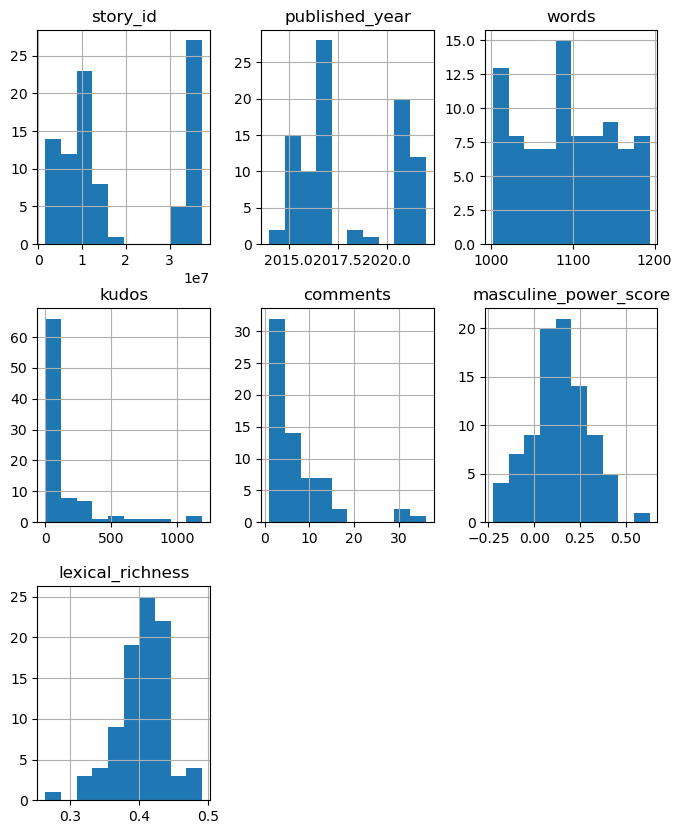

In [35]:
# Q3a (code): Check data distribution
df.hist(figsize=(8,10));

The data of the two new variables *masculine_power_score* and *lexical_richness* demonstrate a bell-shaped curve, exhibiting normal distribution. These data are continuous data.

In [36]:
# Q3b (code): compute some descriptive statistics
df.describe()

,story_id,published_year,words,kudos,comments,masculine_power_score,lexical_richness
count,9.000000e+01,90.000000,90.000000,89.000000,65.000000,90.000000,90.000000
mean,1.839576e+07,2018.088889,1094.344444,135.393258,6.923077,0.139726,0.405027
std,1.307922e+07,2.612177,55.327048,229.972311,7.005149,0.162666,0.037109
min,1.572659e+06,2014.000000,1002.000000,1.000000,1.000000,-0.224953,0.264443
25%,7.448760e+06,2016.000000,1042.250000,20.000000,2.000000,0.045819,0.384458
50%,1.224167e+07,2017.000000,1095.000000,54.000000,5.000000,0.137487,0.410169
75%,3.517148e+07,2021.000000,1141.750000,122.000000,9.000000,0.235858,0.428415
max,3.736347e+07,2022.000000,1194.000000,1190.000000,36.000000,0.631111,0.491349


In [37]:
# Q3c (code): Check for any missing values
df.isnull().sum()
# There are 26 missing values in the entire dataframe.

story_id                  0
published_year            0
words                     0
kudos                     1
comments                 25
story_content             0
masculine_power_score     0
lexical_richness          0
dtype: int64

In [38]:
# Q3d (code): replace all the NA values with zeros and check again Q3c
df.fillna(value=0, inplace=True)

df.isnull().sum()
# All the missing values have been replaced. There are no missing values.

story_id                 0
published_year           0
words                    0
kudos                    0
comments                 0
story_content            0
masculine_power_score    0
lexical_richness         0
dtype: int64

It's always important to visualize the data to inspect the distributions of values for the variables your interested in (do you remember the dinosaur data shown in class?).

**Q4. Create a scatterplot with `masculine_power_score` and `kudos`**

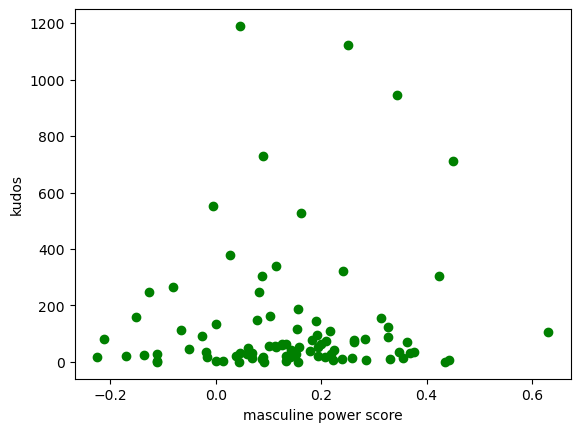

In [39]:
# Q4 (code): Create a scatterplot with masculine_power_score and kudos
masculine_power_score = df['masculine_power_score']
kudos = df['kudos']

plt.scatter(masculine_power_score, kudos, c="g")
plt.xlabel("masculine power score") 
plt.ylabel("kudos")
plt.show()

**Q5. Multiple Regression and Analysis**

In [40]:
# Q5 (code): Do OLS Multiple Regression and print the regression result summary

In [41]:
# Selecting predictors and the target variable
x = df[['masculine_power_score', 'published_year', 'lexical_richness']] # predictors
y = df['kudos'] # target variable (response variable)

In [42]:
from sklearn.metrics import mean_squared_error, r2_score # to calculate the value of R-squared
import statsmodels.api as sm # to conduct OLS multiple regression analysis
import scipy.stats as stats # used for statistics
from sklearn.linear_model import LinearRegression # used for linear regression analysis

In [43]:
# Fitting the multiple linear regression model
model = LinearRegression()
model.fit(x, y) # We want to predict the Y, which is 'kudos'.

# For statsmodels, adding a constant to include an intercept in the model
x_sm = sm.add_constant(x)
model_sm = sm.OLS(y, x_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  kudos   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     5.604
Date:                Fri, 15 Mar 2024   Prob (F-statistic):            0.00147
Time:                        17:18:31   Log-Likelihood:                -608.25
No. Observations:                  90   AIC:                             1224.
Df Residuals:                      86   BIC:                             1234.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   6.98e+

**Q6. Interpret the results of the regression analysis**

**Q6a (words): Interpret the R-squared and Adj. R-squared**<br>
The value of R-squared is 0.164. It indicates that 16.4% of the variability in the kudos can be explained by the model. This entails that a large amount of the variability in the kudos cannot be explained. It may be explained by factors that are not included in the model. The closer R-squared is to 1, the higher the goodness of fit is. As the value of R-squared is 0.164, it is not that close to 1, therefore, the model does not fit well.

The value of adjusted R-squared is 0.134. This value is lower than the value of R-squared, which is normal. The two values are similar in meaning. Adjusted R-squared is used to balance the impact of increasing the number of independent variables on the loss of degrees of freedom. Degrees of freedom is used to correct the sum of squares of residuals and the total sum of squares in R-squared.

**Q6b (words): Interpret F-test result**<br>
The value of the F-test is large, 5.604, and the p-value of the F-test is low, 0.00147 (lower than 0.05). This means that the overall model is statistically significant. We can reject the null hypothesis that the model with no predictors fits the data as well as our model. This suggests that our model, with at least one predictor, significantly predicts the response variable.<br>
Further significance tests need to be conducted on each explanatory variable.

**Q6c (words): Interpret coefficients and t-test result**<br>
For each predictor, a low p-value (<0.05) suggests rejecting the null hypothesis for the corresponding coefficient being zero, indicating a statistically significant relationship between the predictor and the response variable. The only variable for which this is true in our model is *published_year* (coefficient: -34.6046), where the p-value of the t-test is 0.000, which is lower than 0.05. This is the only variable with a statistically significant coefficient, indicating that more recent stories tend to have more kudos.

const (coefficient: 6.98e+04): The constant term is significantly different from zero, which may represent the base number of kudos when all other variables are held at zero.<br>
*masculine_power_score* (coefficient: 75.7380): This variable is not statistically significant (p-value 0.588 > 0.05) with a wide confidence interval, suggesting that the *masculine_power_score* does not significantly impact the number of *kudos* in the given dataset.<br>
*lexical_richness* (coefficient: 389.1865): Similarly to the *masculine_power_score*, *lexical_richness* does not appear to significantly affect the number of *kudos* (p-value 0.525 > 0.05).<br>

In [44]:
model_sm.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,6.98e+04,1.75e+04,3.989,0.000,3.5e+04,1.05e+05
masculine_power_score,75.7380,139.339,0.544,0.588,-201.258,352.734
published_year,-34.6046,8.675,-3.989,0.000,-51.851,-17.358
lexical_richness,389.1865,610.041,0.638,0.525,-823.535,1601.908


Based on the OLS regression results provided, here is an example analysis:

The model's R-squared value of 0.162 indicates that approximately 16.2% of the variability in the kudos can be explained by the model. While this suggests that the model explains a portion of the variability, there remains a significant amount unaccounted for, which might be explained by factors not included in the model.

The adjusted R-squared value of 0.133 takes into account the number of predictors in the model and the number of observations, showing a slight decrease from the R-squared value, which is normal as it adjusts for the number of terms in the model.

Looking at the coefficients:

const (6.995e+04): The constant term is significantly different from zero, which may represent the base number of kudos when all other variables are held at zero.
masculine_power_score (59.7927): This variable is not statistically significant (p-value 0.668) with a wide confidence interval, suggesting that the masculine power score does not significantly impact the number of kudos in the given dataset.
lexical_richness (390.3633): Similar to the masculine power score, lexical richness does not appear to significantly affect the number of kudos (p-value 0.524).
published_year (-34.6801): This is the only variable with a statistically significant coefficient (p-value < 0.001), indicating that more recent stories tend to have fewer kudos.
The large F-statistic (5.561) and its associated low probability (0.00155) suggest that the overall model is statistically significant compared to a model without any predictors.

**Q7: Residual Analysis**

Normality Test, Homoscedasticity Test

In [45]:
# Q7a (code): Calculate residuals and do a Shapiro-Wilk Test
# Predicting and calculating residuals
y_pred = model.predict(x)
residuals = y - y_pred

# Shapiro-Wilk test
_, p_value = stats.shapiro(residuals)
print(f'Shapiro-Wilk test p-value: {p_value}')

Shapiro-Wilk test p-value: 1.7716512935514461e-12


In [46]:
# Q7b (words): Write your analysis for the Normality Test there:
# Shapiro-Wilk test p-value: 1.7716512935514461e-12 (= 0.0000000000017716512935514461)
# The p-value of the Shapiro-Wilk test is below 0.05. Hence, the values are not normally distributed.

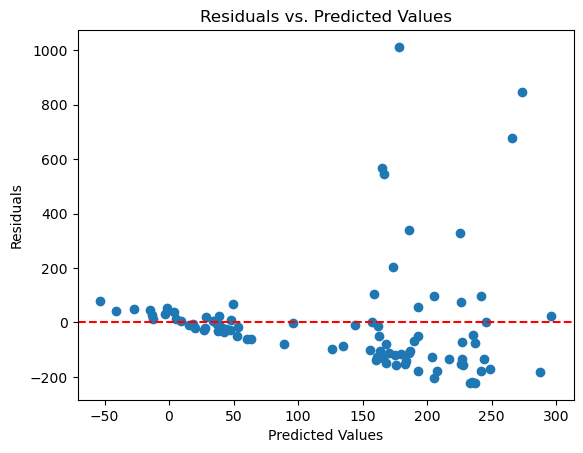

In [47]:
# Q7c (code): Homoscedasticity Test (plot residuals vs. predictions)
plt.scatter(y_pred, residuals)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In the residuals vs. predicted values plot, you would look for patterns. In a well-fitted model, you would expect to see the residuals randomly scattered around zero, with no clear pattern. The presence of a pattern might suggest issues with model specification, such as non-linearity or heteroscedasticity.

**Q7d (words): Write your analysis for the Homoscedasticity Test here:**<br>
The plot shows heteroscedasticity; the variance of residuals is not constant across all levels of the predictor variables.
The spread increases with the predicted values, the data exhibits heteroscedasticity, suggesting that the model may not give equally reliable predictions across all values of the independent variables.

**Q8: Multicollinearity**

In [48]:
# Q8a (code)
# Checking VIF (Variance Inflation Factor) for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))]

print(vif_data)

                 feature         VIF
0  masculine_power_score    1.749306
1         published_year  121.719639
2       lexical_richness  121.815877


Regarding multicollinearity, the VIF values for masculine_power_score, lexical_richness, and published_year are close to 1, which suggests low multicollinearity. However, the very high VIF for the const term, along with the large condition number, suggests that there may be numerical issues, possibly due to a large scale difference between predictors or multicollinearity issues not captured by standard VIF calculations.

**Q8b (words): Write your analysis for the multicollinearity test here:**<br>
The VIF value of *masculine_power_score* is 1.749306, which is not equal to 1 and is lower than 5, therefore this suggests a moderate level of multicollinearity.<br>
The VIF values of *published_year* and *lexical_richness* are 121.719639 and 121.815877, respectively. Both of them are higher than 10, suggesting a high level of multicollinearity.

**Q9: Reflection**

**Q9 (words): Write your reflection on the whole research framework and corresponding result here, e.g., what do you think can be improved?**<br>

The result of the F-test shows that the overall model is statistically significant. We can reject the null hypothesis that the model with no predictors fits the data as well as our model. This suggests that our model, with at least one predictor, significantly predicts the response variable.

*Published_year* is the only variable with a statistically significant coefficient.

The residual analysis demonstrates that the values are not normally distributed and that there is heteroscedasticity.

The VIF values of *published_year* and *lexical_richness* exceed 10. The problem of multicollinearity is present. These variables can be considered to have too much multicollinearity in the model, which can distort the regression coefficients and p-values, making them unreliable or difficult to interpret. In such cases, it is recommended to consider dropping the variable from the model, combining it with another variable. Since according to the t-test result, the estimated parameter for *lexical_richness* is not significant, then we can consider deleting this variable. We can try to form new multiple linear regressions and test the model performance.<br>

We can also conduct a Principal Component Analysis (PCA) to reduce dimensionality. PCA can be used to transform correlated variables into a smaller set of uncorrelated variables (principal components). By using these principal components as predictors in the regression model, we can mitigate multicollinearity.<br>

Correlation matrices may also be used.

##**Reference:**##

Seymour Benjamin Chatman. 1980. Story and Discourse: Narrative Structure in Fiction and Film. Cornell University Press, Ithaca, NY, USA.

Bennet, Andrew, and Nicholas Royle. Introduction to Literature Criticism and Theory. Edinburgh: Pearson Education Limited, 2004.Web.July. 2017.

Reaske, Christoper Russel. Analyze Drama. New York: Monarch Press, 1996. Print.

Jung, Sun “Bae Yong-Joon, Soft Masculinity, and Japanese Fans: Our Past Is in Your Present Body” from Korean Masculinities and Transcultural Consumption, Hong Kong Scholarship Online, 2010.

Kuo, Linda, et al., “Performance, Fantasy, or Narrative: LGBTQ+ Asian American Identity through Kpop Media in Fandom”, Journal of Homosexuality, 2020.

Kwon, Jungmin, Straight Korean Female Fans and Their Gay Fantasies, University of Iowa Press, 2019, ebook.

Oh, Chuyun, “Queering spectatorship in K-pop: The androgynous male dancing body and western female fandom”, Journal of Fandom Studies, vol. 3, no. 1, 2015, pp. 59-78.